# 5-7. 프로젝트: Spectrogram classification 모델 구현

## 1. 데이터 처리와 분류

In [1]:
import numpy as np
import os
import IPython.display as ipd
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import librosa
import librosa.display

### 데이터셋 살펴보기

In [2]:
# 데이터 불러오기

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

print("✅")

✅


In [3]:
print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", speech_data["label_vals"].shape)
print("✅")

Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)
✅


In [4]:
# 데이터 선택
rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)

rand num :  39283
Wave data shape :  (8000,)
label :  ['up']


### 라벨 데이터 처리하기

In [5]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


In [6]:
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

label_data

array([ 3,  3,  3, ..., 11, 11, 11])

### sklearn의 train_test_split함수를 이용하여 train, test 분리

In [7]:
sr = 8000
train_wav, test_wav, train_label, test_label = train_test_split(speech_data["wav_vals"], 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)
print(train_wav)

train_wav = train_wav.reshape([-1, sr])
test_wav = test_wav.reshape([-1, sr])
print("✅")

[[ 3.2938202e-03  4.7343327e-03  8.2739476e-05 ...  2.5882763e-03
   2.0951452e-03 -1.8578675e-03]
 [-1.6788901e-03  9.4865849e-03  2.8868016e-02 ...  3.2217640e-02
   3.7000053e-02 -8.9836400e-03]
 [-5.7642376e-03 -8.2991151e-03 -7.0964107e-03 ... -8.8387122e-03
  -1.0610635e-02 -1.1867483e-02]
 ...
 [-1.3624663e-03 -3.0522561e-04 -6.7514144e-03 ... -2.5682759e-03
  -4.0257266e-03 -7.6274602e-03]
 [ 1.4771124e-05  1.7318946e-07  4.0236557e-07 ...  6.8044465e-04
   6.6723611e-04  7.0410629e-04]
 [ 3.3146022e-03  4.7884230e-03  1.1171027e-04 ...  2.6632592e-03
   2.1714419e-03 -1.8020259e-03]]
✅


In [8]:
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)
print("✅")

train data :  (45558, 8000)
train labels :  (45558,)
test data :  (5062, 8000)
test labels :  (5062,)
✅


### 2차원 Spectogram 으로 변환  

In [9]:
def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D
print("✅")

✅


#### Train data 변환

In [10]:
train_spec=[] 
for wav in train_wav: 
    stft = wav2spec(wav)
    train_spec.append(stft)
train_spec = np.array(train_spec)
print("Spectrogram shape : ",train_spec.shape)

Spectrogram shape :  (45558, 130, 126)


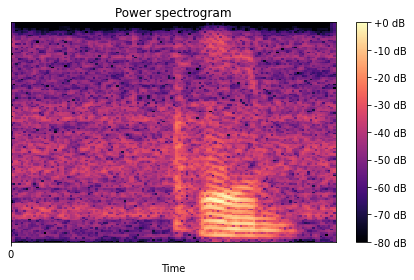

In [11]:
librosa.display.specshow(librosa.amplitude_to_db(train_spec[0], ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

#### Test data 변환

In [12]:
test_spec=[] 
for wav in test_wav: 
    stft = wav2spec(wav)
    test_spec.append(stft)
test_spec = np.array(test_spec)
print("Spectrogram shape : ",test_spec.shape)

Spectrogram shape :  (5062, 130, 126)


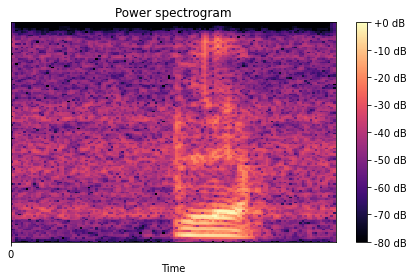

In [13]:
librosa.display.specshow(librosa.amplitude_to_db(test_spec[0], ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

---

## 2. 학습을 위한 하이퍼파라미터 설정

In [14]:
batch_size = 16
max_epochs = 5

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/spec'

checkpoint_dir

'/home/aiffel-dj24/aiffel/speech_recognition/models/spec'

---

## 3. 데이터셋 구성

#### tf.data.Dataset을 이용
#### from_tensor_slices 함수에 return 받길 원하는 데이터를 튜플 (data, label) 형태로 넣어서 사용

In [15]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label
print("✅")

✅


### map과 batch를 이용한 데이터 전처리

In [16]:
# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_spec, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_spec, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)
print("✅")

<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>
✅


---

## 4. 2차원 Spectrogram 데이터를 처리하는 모델 구성

#### 2차원 Spectrogram 데이터의 시간축 방향으로 Conv1D layer를 적용, 혹은 Conv2D layer를 적용 가능

#### batchnorm, dropout, dense layer 등을 이용

### Conv1D model

In [19]:
input_tensor = layers.Input(shape=(130, 126))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_spec = tf.keras.Model(input_tensor, output_tensor)

model_spec.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 130, 126)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 130, 32)           36320     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 130, 32)           9248      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 65, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 65, 64)            18496     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 65, 64)            36928     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 64)            0     

#### 12개의 단어 class를 구분하는 loss를 사용하고 Adam optimizer를 사용

In [20]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_spec.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


### 모델 가중치를 저장하는 checkpoint callback 함수 추가

In [21]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


### 다양한 모델의 실험을 진행해 보시기 바랍니다.

In [22]:
history_spec = model_spec.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_spec) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_spec) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Epoch 1/5
2847/2847 [==============================] - ETA: 0s - loss: 1.3178 - accuracy: 0.5480
Epoch 00001: val_loss improved from inf to 0.71307, saving model to /home/aiffel-dj24/aiffel/speech_recognition/models/spec
2847/2847 [==============================] - 16s 6ms/step - loss: 1.3178 - accuracy: 0.5480 - val_loss: 0.7131 - val_accuracy: 0.7540
Epoch 2/5
2847/2847 [==============================] - ETA: 0s - loss: 0.6357 - accuracy: 0.7898
Epoch 00002: val_loss improved from 0.71307 to 0.49461, saving model to /home/aiffel-dj24/aiffel/speech_recognition/models/spec
2847/2847 [==============================] - 16s 5ms/step - loss: 0.6357 - accuracy: 0.7898 - val_loss: 0.4946 - val_accuracy: 0.8277
Epoch 3/5
2838/2847 [============================>.] - ETA: 0s - loss: 0.4456 - accuracy: 0.8513
Epoch 00003: val_loss improved from 0.49461 to 0.41330, saving model to /home/aiffel-dj24/aiffel/speech_recognition/models/spec
2847/2847 [==============================] - 16s 6ms/step - l

---

## 5. 학습 후, 학습이 어떻게 진행됐는지 그래프로 출력

### loss, accuracy를 그래프로 표현


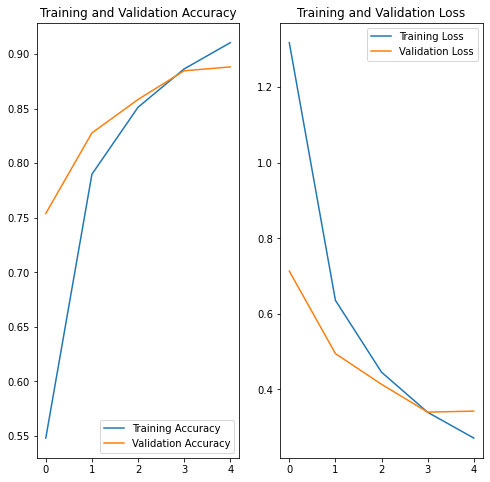

✅


In [23]:
acc = history_spec.history['accuracy']
val_acc = history_spec.history['val_accuracy']

loss=history_spec.history['loss']
val_loss=history_spec.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

---

## 6. Test dataset을 이용해서 모델의 성능을 평가

### 저장한 weight 불러오기

In [24]:
model_spec.load_weights(checkpoint_dir)
print("✅")

✅


### 모델의 예측값과 정답값이 얼마나 일치하는지 확인

In [25]:
results = model_spec.evaluate(test_dataset)
print("✅")

317/317 [==============================] - 17s 52ms/step - loss: 0.3394 - accuracy: 0.8848
✅


In [26]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

loss value: 0.339
accuracy value: 88.4828%
✅


### 모델 테스트

In [32]:
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_spec[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_spec(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(16380,), rate=16380)

label :  on


In [33]:
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')
print("✅")

y_pred: on(Correct!)
✅


---

### Skip-Connection model

In [17]:
input_tensor = layers.Input(shape=(130, 126))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(skip_1)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(skip_3)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_spec_skip = tf.keras.Model(input_tensor, output_tensor)

model_spec_skip.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 130, 126)]   0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 130, 32)      36320       input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 130, 32)      9248        conv1d[0][0]                     
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 65, 32)       0           conv1d_1[0][0]                   
______________________________________________________________________________________________

In [18]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_spec_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


In [19]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/spec_skip'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


In [20]:
history_spec_skip = model_spec_skip.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Epoch 1/5
2844/2847 [============================>.] - ETA: 0s - loss: 1.4409 - accuracy: 0.5084
Epoch 00001: val_loss improved from inf to 0.85113, saving model to /home/aiffel-dj24/aiffel/speech_recognition/models/spec_skip
2847/2847 [==============================] - 17s 6ms/step - loss: 1.4404 - accuracy: 0.5087 - val_loss: 0.8511 - val_accuracy: 0.7108
Epoch 2/5
2841/2847 [============================>.] - ETA: 0s - loss: 0.7265 - accuracy: 0.7592
Epoch 00002: val_loss improved from 0.85113 to 0.53639, saving model to /home/aiffel-dj24/aiffel/speech_recognition/models/spec_skip
2847/2847 [==============================] - 17s 6ms/step - loss: 0.7262 - accuracy: 0.7592 - val_loss: 0.5364 - val_accuracy: 0.8212
Epoch 3/5
2841/2847 [============================>.] - ETA: 0s - loss: 0.4901 - accuracy: 0.8368
Epoch 00003: val_loss improved from 0.53639 to 0.39430, saving model to /home/aiffel-dj24/aiffel/speech_recognition/models/spec_skip
2847/2847 [==============================] - 1

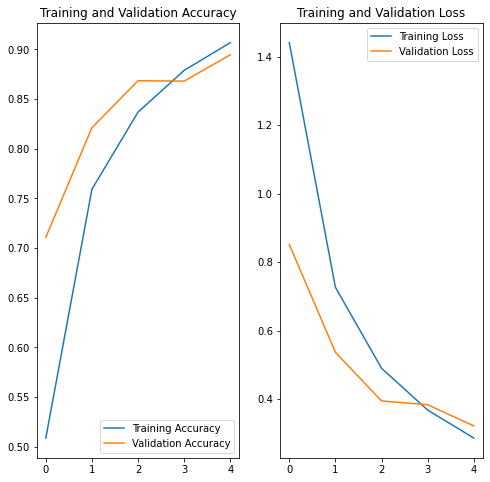

✅


In [22]:
acc = history_spec_skip.history['accuracy']
val_acc = history_spec_skip.history['val_accuracy']

loss=history_spec_skip.history['loss']
val_loss=history_spec_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

In [23]:
# Evaluation 
model_spec_skip.load_weights(checkpoint_dir)
results = model_spec_skip.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))

# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

317/317 [==============================] - 17s 53ms/step - loss: 0.3211 - accuracy: 0.8947
loss value: 0.321
accuracy value: 89.4706%
✅


In [28]:
# Test 

inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_spec[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_spec_skip(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(16380,), rate=16380)

label :  on


In [29]:
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')
print("✅")

y_pred: on(Correct!)
✅


---

## 루브릭 평가

__1. 음성데이터를 2차원 Spectrogram 으로 변환하여 데이터셋을 구성하였다.__  
_(스펙트로그램 시각화 및 train/test 데이터셋 구성이 정상진행되었다.)_

- 음성데이터를 Train data와 Test data으로 먼저 나눈 뒤 2차둰 Spectogramd으로 변환 및 시각화 했다.

__2. 1,2차원 데이터를 처리하는 음성인식 모델이 정상 작동한다.__  
_(스펙트로그램을 입력받은 모델이 학습과정에서 안정적으로 수렴하며, evaluation/test 단계를 무리없이 진행가능하다.)_

- 2가지 모델을 진행했고, 두 모델 모두 정상적으로 작동했다.

__3. 테스트셋 수행결과 음성인식 모델의 Accuracy가 일정 수준에 도달하였다.__  
_(evaluation 결과 75% 이상의 정확도를 달성하는 모델이 하나 이상 존재한다.)_

- 2가지 모델 각각 약 88%, 89%의 정확도를 달성했다.

---

## 회고

__1. 프로젝트 진행시 어려웠던 점__

- GPU 초과로 인해 커널이 죽었던 점 : 재부팅을 통해 해결
- 1차원 WAV 데이터를 2차원인 Spectogram으로 변환하는 방법 : 슬랙의 질문하기에서 힌트를 얻을 수 있었다.
- 변환된 Spectogram 데이터에 맞춰 인수를 변경하는 것

__2. 프로젝트를 진행하면서 알아낸 점 또는 아직 모호한 점__

- 알아낸 점 : 1차원인 WAV보다 2차원인 Spectogram으로 변환 후 모델 학습시 소요되는 시간이 비교적 적었다.
- 모호한 점 : 마지막 Test에서 오디오를 들으면 노이즈 밖에 들리지 않는다. 

__3.  루브릭 평가 지표를 맞추기 위해 시도한 점__

- 음성 데이터를 Spectogram으로 변환시키기 위해 numpy에 대해여 찾아보았다.
- 모델을 빠르고 정확하게 학습시키기 위하여 여러 하이퍼파라미터를 조정해 동작해 보았다.

__4. 루브릭 평가 지표를 달성하지 못한 이유__

- 없음

__5.  프로젝트 진행 후 느낀 점 및 다짐__

- 자연어와 이미지에 국한되어 있던 나만의 인공지능 활용성 범위를 확장해준 괜찮은 노드였다.
- 하지만 음성 데이터는 한동안 건들면 안될 것 같다. (많은 실력이 필요한 것 같다. ㅠㅠ)
- 프로젝트 진행시 노드에 나와있는 대로 하기보단 실패하더라도 내가 생각한 방향으로 진행하는 것이 맞는 것 같다. 처음에 잘 진행하다가 노드 상의 순서에 집착해 먼 길을 돌아왔다.